There are two ways of collecting and analyzing NGINX logs in AWS:

1. Download all the logentries from Cloudwatch filtered on `StreamPrefix='application/nginx'`` and analyze them locally
2. Execute a query with boto3 and analyze the results

In [16]:
%pip install boto3 prettytable pandas

Note: you may need to restart the kernel to use updated packages.


In [17]:
import boto3
import subprocess
import json
import os
import time, pytz
import re
import random
import pandas as pd
from botocore.exceptions import ClientError
from datetime import datetime, timezone, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed

os.environ['TZ'] = 'UTC'
time.tzset()

import sys
sys.path.append('..')
from awsutils import *

In [18]:
def create_session(profile_name='acl-production', region='eu-central-1'):
    global aws_session, sts_client, logs_client

    # Use the function with your profile to get a session
    aws_session = set_aws_credentials(profile_name, region)

    # Create clients using the session
    sts_client = aws_session.client('sts')
    logs_client = aws_session.client('logs')

    # Example usage of the clients
    account_id = sts_client.get_caller_identity()["Account"]
    print("Current AWS Account ID:", account_id)

create_session()

Current AWS Account ID: 707785685172


# Analyze logs with boto3

In [19]:
def fetch_slices(logs_client, log_group, base_query, start_date, end_date, file_name, slices=100):
    slice_duration = (end_date - start_date) / slices
    query = base_query + f" | limit 10000"

    future_to_task = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        for i in range(slices):
            # Calculate the start and end timestamps for the current time slice
            start_timestamp = int(start_date + (i * slice_duration))
            end_timestamp = int(start_date + ((i + 1) * slice_duration))
        
            # print time slice in human readable format (original format is epoch time in seconds)
            print(f"Time slice {i}: {datetime.fromtimestamp(start_timestamp, tz=pytz.timezone('UTC'))} - {datetime.fromtimestamp(end_timestamp, tz=pytz.timezone('UTC'))}")

            future_to_task.append(executor.submit(
                cloudwatch_query, logs_client, log_group, query, start_timestamp, end_timestamp))
            
        for future in as_completed(future_to_task):
            # print the number of log entries in each time slice
            print("Number of log entries:", len(future.result()))

            # append results from each time slice to a file
            try:
                with open(file_name, 'a') as f:
                    f.write(json.dumps(future.result()))
                    f.write('\n')
            except ClientError as e:
                if e.response['Error']['Code'] == 'AccessDeniedException':
                    print("Session expired")
                    create_session()
                else:
                    print("Unexpected error: %s" % e)

In [20]:


#log_group = 'projects-main'
log_group =  'api_proxy-main'

base_query = f"fields @timestamp, @message | filter @logStream like 'application/nginx'"
start_date = exact_date(2024, 6, 12)
end_date = exact_date(2024, 6, 13)


date = datetime.fromtimestamp(start_date)

# clear the file before appending new data
file_name=f'nginx_{log_group}_{date.strftime("%Y%m%d")}.json'
with open(file_name, 'w') as f:
    f.write('')
# fetch the log data in slices
fetch_slices(logs_client, log_group, base_query, start_date, end_date, file_name, slices=400)
print("Done.")

Time slice 0: 2024-06-12 00:00:00+00:00 - 2024-06-12 00:03:36+00:00
Time slice 1: 2024-06-12 00:03:36+00:00 - 2024-06-12 00:07:12+00:00
Time slice 2: 2024-06-12 00:07:12+00:00 - 2024-06-12 00:10:48+00:00
Time slice 3: 2024-06-12 00:10:48+00:00 - 2024-06-12 00:14:24+00:00
Time slice 4: 2024-06-12 00:14:24+00:00 - 2024-06-12 00:18:00+00:00
Time slice 5: 2024-06-12 00:18:00+00:00 - 2024-06-12 00:21:36+00:00
Time slice 6: 2024-06-12 00:21:36+00:00 - 2024-06-12 00:25:12+00:00
Time slice 7: 2024-06-12 00:25:12+00:00 - 2024-06-12 00:28:48+00:00
Time slice 8: 2024-06-12 00:28:48+00:00 - 2024-06-12 00:32:24+00:00
Time slice 9: 2024-06-12 00:32:24+00:00 - 2024-06-12 00:36:00+00:00
Time slice 10: 2024-06-12 00:36:00+00:00 - 2024-06-12 00:39:36+00:00
Time slice 11: 2024-06-12 00:39:36+00:00 - 2024-06-12 00:43:12+00:00
Time slice 12: 2024-06-12 00:43:12+00:00 - 2024-06-12 00:46:48+00:00
Time slice 13: 2024-06-12 00:46:48+00:00 - 2024-06-12 00:50:24+00:00
Time slice 14: 2024-06-12 00:50:24+00:00 - 2

In [21]:
def normalize_request_path(request):
    # Remove "HTTP/1.1" if it exists at the end
    request = re.sub(r' HTTP/1.1$', '', request)

    # Regular expression to identify and replace numeric IDs in the request path
    return re.sub(r'([/=])\d+', r'\1{id}', request)

def aggregate_requests(aggregated_data, data):
    for entry in data:
        try:
            request = entry["@message"]["request"]
            normalized_request = normalize_request_path(request)
            request_time = int(float(entry["@message"]["request_time"]) * 1000)  # Convert to milliseconds

            if normalized_request in aggregated_data:
                aggregated_data[normalized_request]['count'] += 1
                aggregated_data[normalized_request]['total_duration'] += request_time
            else:
                aggregated_data[normalized_request] = {'count': 1, 'total_duration': request_time}
        except KeyError:
            continue
        except Exception as e:
            print("Error processing entry:", entry)
            print(e)
            continue


In [ ]:
# load the json file with log entries into a list
aggregated_data = {}

log_files = ['api_proxy-nginx_20240610.json']
item_count=0
        
for fname in log_files:
    with open(fname, 'r') as f:
        for line in f:
            data = json.loads(line)
            item_count += len(data)
            print(f'\rnumber of log entries: {item_count}', end="")
            parse_json_messages(data)
            aggregate_requests(aggregated_data, data)



# Load NGINX logs and put it into a DB

In [5]:
import os, json, sqlite3
import psycopg2
from psycopg2 import sql

def process_log_files(log_files, table_names, postgres_config):
    if len(log_files) != len(table_names):
        raise ValueError("The number of log files must match the number of table names")
    
    conn = psycopg2.connect(**postgres_config)
    c = conn.cursor()

    for fname, table_name in zip(log_files, table_names):
        item_count = 0

        # Create table
        create_table_query = sql.SQL('''CREATE TABLE IF NOT EXISTS {table_name} (
                                    timestamp TEXT, 
                                    message TEXT, 
                                    time_local TEXT, 
                                    client TEXT, 
                                    ACL_Cloudfront TEXT, 
                                    method TEXT, 
                                    scheme TEXT, 
                                    host TEXT, 
                                    request TEXT,                                      
                                    request_length BIGINT,
                                    status INTEGER, 
                                    bytes_sent INTEGER, 
                                    body_bytes_sent INTEGER, 
                                    referrer TEXT, 
                                    user_agent TEXT, 
                                    request_time REAL, 
                                    remote_user TEXT, 
                                    x_nginx_id TEXT, 
                                    x_request_id TEXT, 
                                    upstream_status INTEGER, 
                                    upstream_response_time REAL, 
                                    upstream_connect_time REAL, 
                                    upstream_header_time REAL)''').format(table_name=sql.Identifier(table_name))
        c.execute(create_table_query)

        # Create indexes
        create_index_query_1 = sql.SQL('''CREATE INDEX IF NOT EXISTS {index_name} ON {table_name} (x_nginx_id)''').format(
            index_name=sql.Identifier(f'idx_{table_name}_x_nginx_id'),
            table_name=sql.Identifier(table_name)
        )
        create_index_query_2 = sql.SQL('''CREATE INDEX IF NOT EXISTS {index_name} ON {table_name} (x_request_id)''').format(
            index_name=sql.Identifier(f'idx_{table_name}_x_request_id'),
            table_name=sql.Identifier(table_name)
        )
        c.execute(create_index_query_1)
        c.execute(create_index_query_2)

        with open(fname, 'r') as f:
            for line in f:
                data = json.loads(line)
                item_count += len(data)

                for entry in data:
                    try:
                        # parse the @message field
                        message = json.loads(entry["@message"])

                        def parse_int(value):
                            try:
                                return int(value)
                            except ValueError:
                                return None

                        def parse_float(value):
                            try:
                                return float(value)
                            except ValueError:
                                return None
                        
                        # Map the JSON keys to match the database column names
                        log_entry = {
                            'timestamp': entry["@timestamp"],
                            'message': entry["@message"],
                            'time_local': message["time_local"],
                            'client': message["client"],
                            'ACL_Cloudfront': message.get("ACL_Cloudfront", ""),
                            'method': message["method"],
                            'scheme': message["scheme"],
                            'host': message["host"],
                            'request': message["request"],
                            'request_length': parse_int(message["request_length"]),
                            'status': parse_int(message["status"]),
                            'bytes_sent': parse_int(message["bytes_sent"]),
                            'body_bytes_sent': parse_int(message["body_bytes_sent"]),
                            'referrer': message["referrer"],
                            'user_agent': message["user_agent"],
                            'request_time': parse_float(message["request_time"]),
                            'remote_user': message.get("remote_user", ""),
                            'x_nginx_id': message["x_nginx_id"],
                            'x_request_id': message["x_request_id"],
                            'upstream_status': parse_int(message["upstream_status"]),
                            'upstream_response_time': parse_float(message["upstream_response_time"]),
                            'upstream_connect_time': parse_float(message["upstream_connect_time"]),
                            'upstream_header_time': parse_float(message["upstream_header_time"])
                        }

                        insert_query = sql.SQL("""
                            INSERT INTO {table_name} (timestamp, message, time_local, client, ACL_Cloudfront, method, scheme, host, request, request_length, status, bytes_sent, body_bytes_sent, referrer, user_agent, request_time, remote_user, x_nginx_id, x_request_id, upstream_status, upstream_response_time, upstream_connect_time, upstream_header_time)
                            VALUES (%(timestamp)s, %(message)s, %(time_local)s, %(client)s, %(ACL_Cloudfront)s, %(method)s, %(scheme)s, %(host)s, %(request)s, %(request_length)s, %(status)s, %(bytes_sent)s, %(body_bytes_sent)s, %(referrer)s, %(user_agent)s, %(request_time)s, %(remote_user)s, %(x_nginx_id)s, %(x_request_id)s, %(upstream_status)s, %(upstream_response_time)s, %(upstream_connect_time)s, %(upstream_header_time)s)
                        """).format(table_name=sql.Identifier(table_name))
                        c.execute(insert_query, log_entry)
                    except KeyError:
                        continue
                    except Exception as e:
                        print("Error processing entry:", entry)
                        print(e)
                        continue

                print(f'\rnumber of log entries for {table_name}: {item_count}', end="")

    conn.commit()
    conn.close()


log_files = [
    'nginx_api_proxy-main_20240610.json', 'nginx_api_proxy-main_20240611.json', 'nginx_api_proxy-main_20240612.json',
    'nginx_projects-main_20240610.json', 'nginx_projects-main_20240611.json', 'nginx_projects-main_20240612.json'
]
table_names = [
    'api_proxy_logs', 'api_proxy_logs', 'api_proxy_logs',
    'project_logs', 'project_logs', 'project_logs'
]

postgres_config = {
    'dbname': 'nginx_logs',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'
}

process_log_files(log_files, table_names, postgres_config)

number of log entries for api_proxy_logs: 60000Error processing entry: {'@timestamp': '2024-06-10 00:07:04.865', '@message': '2024/06/10 00:07:04 [error] 91#0: *3 connect() failed (111: Connection refused) while connecting to upstream, client: 10.185.254.176, server: _, request: "GET /health-check-elb HTTP/1.1", upstream: "http://127.0.0.1:9000/health-check-elb", host: "10.185.45.200:2000"\r', '@ptr': 'CnEKLwobNzA3Nzg1Njg1MTcyOmFwaV9wcm94eS1tYWluEAQiDgjAt9T7/zEQ59bh+/8xEjoaGAIGYot6oAAAAAF+GUEVAAZmZDUAAAAAAiABKOjM2/v/MTCUqeT7/zE41z9Au+XUAUjv5BdQ6r4XGAAgARDeKRgB'}
Extra data: line 1 column 5 (char 4)
Error processing entry: {'@timestamp': '2024-06-10 00:07:04.861', '@message': '2024/06/10 00:07:04 [error] 91#0: *1 connect() failed (111: Connection refused) while connecting to upstream, client: 10.185.255.207, server: _, request: "GET /health-check-elb HTTP/1.1", upstream: "http://127.0.0.1:9000/health-check-elb", host: "10.185.45.200:2000"\r', '@ptr': 'CnEKLwobNzA3Nzg1Njg1MTcyOmFwaV9wcm9

KeyboardInterrupt: 

# Import data to Postgres from file

First run:

`$ psql postgres`

`postgres=# create database nginx_logs;`

`postgres=# create user postgres with encrypted password 'postgres';`

`postgres=# grant all privileges on database nginx_logs to postgres;`


In [2]:
import os
import json
import csv
import psycopg2
from psycopg2 import sql

def create_table(postgres_config, table_name):
    with psycopg2.connect(**postgres_config) as conn:
        with conn.cursor() as c:
            create_table_query = sql.SQL('''CREATE TABLE IF NOT EXISTS {table_name} (
                                    timestamp TEXT, 
                                    message TEXT, 
                                    time_local TEXT, 
                                    client TEXT, 
                                    ACL_Cloudfront TEXT, 
                                    method TEXT, 
                                    scheme TEXT, 
                                    host TEXT, 
                                    request TEXT, 
                                    request_length BIGINT, 
                                    status INTEGER, 
                                    bytes_sent INTEGER, 
                                    body_bytes_sent INTEGER, 
                                    referrer TEXT, 
                                    user_agent TEXT, 
                                    request_time REAL, 
                                    remote_user TEXT, 
                                    x_nginx_id TEXT, 
                                    x_request_id TEXT, 
                                    upstream_status INTEGER, 
                                    upstream_response_time REAL, 
                                    upstream_connect_time REAL, 
                                    upstream_header_time REAL)''').format(table_name=sql.Identifier(table_name))
            c.execute(create_table_query)

            # Create indexes
            create_index_query_1 = sql.SQL('''CREATE INDEX IF NOT EXISTS {index_name} ON {table_name} (x_nginx_id)''').format(
                index_name=sql.Identifier(f'idx_{table_name}_x_nginx_id'),
                table_name=sql.Identifier(table_name)
            )
            create_index_query_2 = sql.SQL('''CREATE INDEX IF NOT EXISTS {index_name} ON {table_name} (x_request_id)''').format(
                index_name=sql.Identifier(f'idx_{table_name}_x_request_id'),
                table_name=sql.Identifier(table_name)
            )
            c.execute(create_index_query_1)
            c.execute(create_index_query_2)


def json_to_csv(json_file, csv_file):
    if os.path.exists(csv_file):
        return

    with open(json_file, 'r') as f, open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header_written = False

        for line in f:
            data = json.loads(line)
            for entry in data:
                try:
                    message = json.loads(entry["@message"])

                    def parse_int(value):
                        try:
                            return int(value)
                        except ValueError:
                            return None

                    def parse_float(value):
                        try:
                            return float(value)
                        except ValueError:
                            return None

                    log_entry = {
                        'timestamp': entry["@timestamp"],
                        'message': entry["@message"],
                        'time_local': message["time_local"],
                        'client': message["client"],
                        'ACL_Cloudfront': message.get("ACL_Cloudfront", ""),
                        'method': message["method"],
                        'scheme': message["scheme"],
                        'host': message["host"],
                        'request': message["request"],
                        'request_length': parse_int(message["request_length"]),
                        'status': parse_int(message["status"]),
                        'bytes_sent': parse_int(message["bytes_sent"]),
                        'body_bytes_sent': parse_int(message["body_bytes_sent"]),
                        'referrer': message["referrer"],
                        'user_agent': message["user_agent"],
                        'request_time': parse_float(message["request_time"]),
                        'remote_user': message.get("remote_user", ""),
                        'x_nginx_id': message["x_nginx_id"],
                        'x_request_id': message["x_request_id"],
                        'upstream_status': parse_int(message["upstream_status"]),
                        'upstream_response_time': parse_float(message["upstream_response_time"]),
                        'upstream_connect_time': parse_float(message["upstream_connect_time"]),
                        'upstream_header_time': parse_float(message["upstream_header_time"])
                    }

                    if not header_written:
                        writer.writerow(log_entry.keys())
                        header_written = True

                    writer.writerow(log_entry.values())

                except KeyError:
                    continue
                except Exception as e:
                    print("Error processing entry:", entry)
                    print(e)
                    continue


def import_csv(postgres_config, csv_file, table_name):
    with psycopg2.connect(**postgres_config) as conn:
        with conn.cursor() as c:
            # Use COPY FROM to import data from CSV
            with open(csv_file, 'r') as f:
                copy_query = sql.SQL("COPY {table_name} FROM STDIN WITH CSV HEADER").format(table_name=sql.Identifier(table_name))
                c.copy_expert(copy_query, f)
            
            print(f"Loaded data from {csv_file} into {table_name}")


def process_log_files(log_files, table_names, postgres_config):
    if len(log_files) != len(table_names):
        raise ValueError("The number of log files must match the number of table names")
    
    for fname, table_name in zip(log_files, table_names):
        # Create CSV file from JSON
        csv_file = fname.replace('.json', '.csv')

        json_to_csv(fname, csv_file)
        create_table(postgres_config, table_name)
        import_csv(postgres_config, csv_file, table_name)
        

log_files = [
    'nginx_api_proxy-main_20240610.json', 'nginx_api_proxy-main_20240611.json', 'nginx_api_proxy-main_20240612.json',
    'nginx_projects-main_20240610.json', 'nginx_projects-main_20240611.json', 'nginx_projects-main_20240612.json'
]
table_names = [
    'api_proxy_logs', 'api_proxy_logs', 'api_proxy_logs',
    'project_logs', 'project_logs', 'project_logs'
]

postgres_config = {
    'dbname': 'nginx_logs',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'
}

process_log_files(log_files, table_names, postgres_config)


Loaded data from nginx_api_proxy-main_20240610.csv into api_proxy_logs
Loaded data from nginx_api_proxy-main_20240611.csv into api_proxy_logs
Loaded data from nginx_api_proxy-main_20240612.csv into api_proxy_logs
Loaded data from nginx_projects-main_20240610.csv into project_logs
Loaded data from nginx_projects-main_20240611.csv into project_logs
Loaded data from nginx_projects-main_20240612.csv into project_logs


In [5]:
import psycopg2

def join_tables(postgres_config):
    with psycopg2.connect(**postgres_config) as conn:
        with conn.cursor() as c:
            join_query = f'''
                -- combine the two logs
                CREATE TABLE combined_logs AS
                WITH unique_x_request_ids AS (
                    SELECT t1.x_request_id
                    FROM api_proxy_logs t1
                    INNER JOIN project_logs t2 ON t1.x_request_id = t2.x_request_id
                    GROUP BY t1.x_request_id
                    HAVING COUNT(t2.x_request_id) = 1 -- only those count which can be paired
                )
                SELECT t1.x_request_id,
                        -- because the timestamp is being created at the end of the request, 
                        -- it must be corrected with the request_time to point to the start
                        to_timestamp(EXTRACT(EPOCH FROM (t1.timestamp::timestamp)) - t1.request_time) as timestamp1,
                        to_timestamp(EXTRACT(EPOCH FROM (t2.timestamp::timestamp)) - t2.request_time) as timestamp2,
                    (EXTRACT(EPOCH FROM (t2.timestamp::timestamp)) - t2.request_time) - (EXTRACT(EPOCH FROM (t1.timestamp::timestamp)) - t1.request_time) as timediff
                FROM unique_x_request_ids as t3
                JOIN api_proxy_logs t1 ON t1.x_request_id = t3.x_request_id
                JOIN project_logs t2 ON t2.x_request_id = t3.x_request_id;
            '''
            print(join_query)

            c.execute(join_query)

postgres_config = {
    'dbname': 'nginx_logs',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'
}

join_tables(postgres_config)



        SELECT ABS(EXTRACT(EPOCH FROM t1.timestamp) - EXTRACT(EPOCH FROM t2.timestamp)) as delay, 
                t1.timestamp as timestamp1, t2.timestamp as timestamp2 
        FROM api_proxy_logs t1
        JOIN project_logs t2
        ON t1.x_request_id = t2.x_request_id
        WHERE ABS(EXTRACT(EPOCH FROM t1.timestamp) - EXTRACT(EPOCH FROM t2.timestamp)) > 0
        /* ORDER BY delay DESC */
     LIMIT 100


UndefinedFunction: function pg_catalog.extract(unknown, text) does not exist
LINE 2:         SELECT ABS(EXTRACT(EPOCH FROM t1.timestamp) - EXTRAC...
                           ^
HINT:  No function matches the given name and argument types. You might need to add explicit type casts.


# Select statistics


                    with requestids as (
                    select x_request_id, timediff
                    from combined_logs
                    --where timediff < -10
                )
                select t1.timestamp as timestamp1, t1.upstream_response_time - t2.request_time as delay
                from requestids as t3
                join api_proxy_logs as t1 on t1.x_request_id = t3.x_request_id
                join project_logs as t2 on t2.x_request_id = t3.x_request_id
                where t1.status >= 200 and t1.status < 300
                order by t1.timestamp
                --limit 10000;
            
8655797


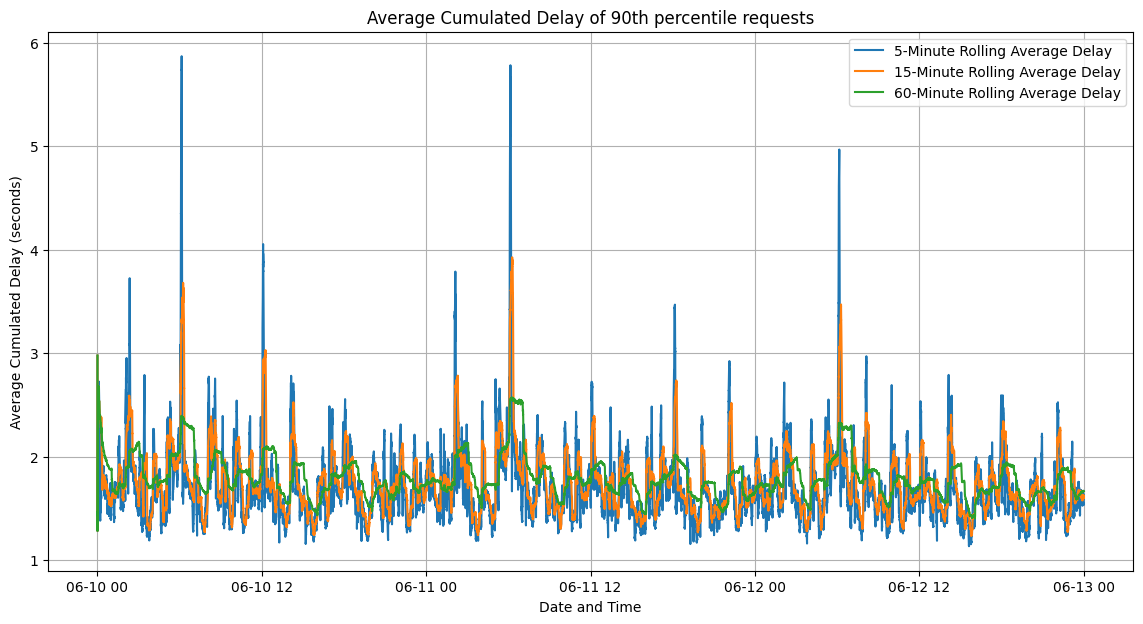

In [8]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

def fetch_data(postgres_config):
    with psycopg2.connect(**postgres_config) as conn:
        with conn.cursor() as c:
            query = f'''
                    with requestids as (
                    select x_request_id, timediff
                    from combined_logs
                    --where timediff < -10
                )
                select t1.timestamp as timestamp1, t1.upstream_response_time - t2.request_time as delay
                from requestids as t3
                join api_proxy_logs as t1 on t1.x_request_id = t3.x_request_id
                join project_logs as t2 on t2.x_request_id = t3.x_request_id
                where t1.status >= 200 and t1.status < 300
                order by t1.timestamp
                --limit 10000;
            '''
            print(query)

            c.execute(query)  
            data = c.fetchall()
            print(len(data))
            return data
            

postgres_config = {
    'dbname': 'nginx_logs',
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432'
}

def prepare_dataframe(data):
    df = pd.DataFrame(data, columns=['timestamp', 'delay'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    return df

def plot_cumulative_delay(df):
    # Calculate the 90th percentile
    percentile_90 = df['delay'].quantile(0.9)

    # Filter the DataFrame to include only values above the 90th percentile
    df = df[df['delay'] >= percentile_90].copy()
    
    # Calculate the rolling average delay with a 5-minute window
    df['cumulative_delay_5min'] = df['delay'].rolling('5min').mean()
    df['cumulative_delay_15min'] = df['delay'].rolling('15min').mean()
    df['cumulative_delay_60min'] = df['delay'].rolling('60min').mean()

    # Plot the cumulative delays
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['cumulative_delay_5min'], label='5-Minute Rolling Average Delay')
    plt.plot(df.index, df['cumulative_delay_15min'], label='15-Minute Rolling Average Delay')
    plt.plot(df.index, df['cumulative_delay_60min'], label='60-Minute Rolling Average Delay')
    plt.title('Average Cumulated Delay of 90th percentile requests')
    plt.xlabel('Date and Time')
    plt.ylabel('Average Cumulated Delay (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fetch and prepare data
data = fetch_data(postgres_config)
df = prepare_dataframe(data)

# Plot the cumulative delay
plot_cumulative_delay(df)

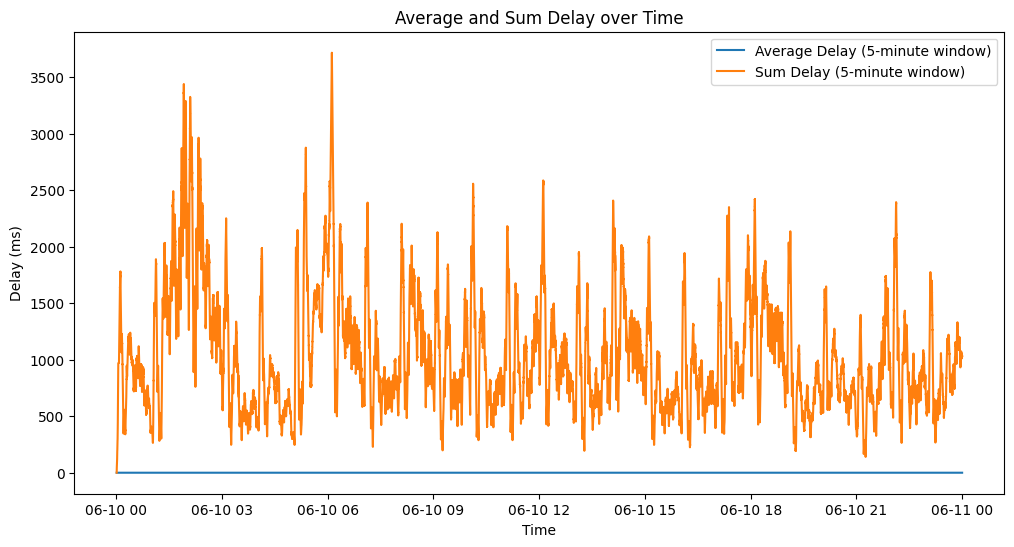

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

def process_data(rows):
    data = []
    for row in rows:
        delay, t1_timestamp, t2_timestamp = row
        data.append((datetime.strptime(t1_timestamp, '%Y-%m-%d %H:%M:%S.%f'), delay))
        data.append((datetime.strptime(t2_timestamp, '%Y-%m-%d %H:%M:%S.%f'), delay))
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=['timestamp', 'delay'])
    df.sort_values('timestamp', inplace=True)

    return df

def plot_average_delay(df):
    # Calculate rolling average delay in a 5-minute window
    df.set_index('timestamp', inplace=True)
    df['rolling_avg_delay'] = df['delay'].rolling('300s').mean()
    df['rolling_sum_delay'] = df['delay'].rolling('300s').sum()

    # Plot the average and sum delay over time
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df['rolling_avg_delay'], label='Average Delay (5-minute window)')
    ax.plot(df.index, df['rolling_sum_delay'], label='Sum Delay (5-minute window)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Delay (ms)')
    ax.set_title('Average and Sum Delay over Time')
    ax.legend()
    plt.show()
    
    

df = process_data(joined_data)
plot_average_delay(df)

In [ ]:


# Print the top 10 requests by total duration in a table
df = pd.DataFrame.from_dict(aggregated_data, orient='index')
df['avg_duration'] = round(df['total_duration'] / df['count'], 2)
df = df.sort_values('total_duration', ascending=False)
df = df.reset_index()
df.columns = ['request', 'count', 'total_duration', 'avg_duration']

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Request", "Count", "Total Duration", "Average Duration"]
x.align["Request"] = "l"
for index, row in df.head(50).iterrows():
    # truncate the request path to 80 characters    
    request = row['request'][:80] + '...' if len(row['request']) > 50 else row['request']
    x.add_row([request, row['count'], timedelta(milliseconds=row['total_duration']), row['avg_duration']])
print(x)




In [ ]:
SELECT ABS(EXTRACT(EPOCH FROM cast(t1.timestamp as timestamp)) - EXTRACT(EPOCH FROM cast(t2.timestamp as timestamp))) as delay, 
                cast(t1.timestamp as timestamp) as timestamp1, cast(t2.timestamp as timestamp) as timestamp2 
        FROM api_proxy_logs t1
        JOIN project_logs t2
        ON t1.x_request_id = t2.x_request_id
        WHERE ABS(EXTRACT(EPOCH FROM cast(t1.timestamp as timestamp)) - EXTRACT(EPOCH FROM cast(t2.timestamp as timestamp))) > 1000
        /* ORDER BY delay DESC */
     LIMIT 100;

# Collect logs from Cloudwatch

In [ ]:
# select 'projects-main' log group and collect log streams starting with 'application/nginx/'
# get log entries based on a time frame ginven in parameters

def get_log_entries(logs_client, log_group_name, log_stream_prefix, start_time, end_time):
    paginator = logs_client.get_paginator('filter_log_events')
    response_iterator = paginator.paginate(
        logGroupName=log_group_name,
        logStreamNamePrefix=log_stream_prefix,
        startTime=start_time,
        endTime=end_time,
        #PaginationConfig={'MaxItems': 1000}
    )
    log_events = []
    for response in response_iterator:
        log_events += response['events']
    return log_events

log_group_name = 'projects-main'
log_stream_name_prefix = 'application/nginx'

start_time = int(datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc).timestamp() * 1000)  # 1st Jan 2024
end_time = int(datetime(2024, 1, 3, 0, 0, 0, tzinfo=timezone.utc).timestamp() * 1000)   # 2nd Jan 2024

log_events = get_log_entries(logs_client, log_group_name, log_stream_name_prefix, start_time, end_time)
print("Number of log events:", len(log_events))

# print the top 100 entries
for log_event in log_events[:100]:
    print(log_event['message'])


In [ ]:
with open('log_data_20240122.json', 'r') as f:
    for line in f:
        data = json.loads(line)
        item_count += len(data)
        print(f'\rnumber of log entries: {item_count}', end="")
        parse_json_messages(data)

number of log entries: 12925924

In [ ]:
print(json.dumps(data[0], indent=4, sort_keys=True))

{
    "@message": {
        "ACL_Cloudfront": "",
        "body_bytes_sent": "2787",
        "bytes_sent": "3816",
        "client": "10.185.255.192",
        "host": "projects-eu.highbond.com",
        "method": "GET",
        "referrer": "",
        "remote_user": "chris@satorigroup.in",
        "request": "GET /api/v3/controls/1696230/control_performance_schedules?org_id=3983&fields%5Bcontrol_performance_schedules%5D=enabled%2Cfrequency_type%2Csent%2Cfrequency_days%2Cfrequency_run_at%2Cfrequency_starts_on%2Cperformer_contact_emails%2Cfrequency_timezone%2Ccreated_at%2Cupdated_at%2Cfrequency_run_at%2Cfrequency_timezone_offset HTTP/1.1",
        "request_length": "4097",
        "request_time": "0.120",
        "scheme": "http",
        "status": "200",
        "time_local": "22/Jan/2024:23:00:00 +0000",
        "upstream_connect_time": "0.004",
        "upstream_header_time": "0.120",
        "upstream_response_time": "0.120",
        "upstream_status": "200",
        "user_agent": "p

In [ ]:
# 2024-06-18 9:38 CET   api_proxy tasks 8 --> 32